In [10]:

import numpy as np
import rioxarray as rx
import rasterio
from rasterio.mask import mask
from pathlib import Path
import geopandas as gpd
import pprint
import re
import os
import glob
import xarray as xr
import matplotlib.pyplot as plt
import xarray
import pandas as pd
from exactextract import exact_extract
%matplotlib inline
%run py/processing_functions.py
  
# set scientific notation to non scientific
np.set_printoptions(suppress=True, precision=6)

In [2]:
def raster_stats(ras):
  median =  ras.median()
  mean = ras.mean()
  std = ras.std()
  median = median.to_pandas()
  mean = mean.to_pandas()
  std = std.to_pandas()
  cv = std/mean
  return (mean, median, cv)
    
def calc_rbr(ras):
    '''returns a new raster consisting of rbr (2) , and a dataframe consisting of median, mean and cv rbr'''
    pre = ras[0]
    post = ras[1]
    post = post.assign_coords({
    "x": pre.x,
    "y": pre.y,})
    new_raster=(((pre - post)*1000)/ pre + 1.001)
    mean, median, cv = raster_stats(new_raster)
    df = pd.DataFrame({
    "Fire_ID": [name],
    "rbr_median": [median],
    "rbr_mean": [mean],
    "rbr_cv": [cv]
    })
    return (df, new_raster)



[{'type': 'Feature',
  'properties': {'median': 329.2703552246094,
   'max': 678.3739013671875,
   'mean': 296.1768493652344}}]

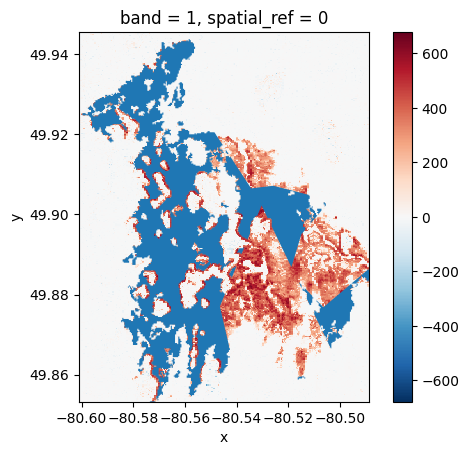

In [11]:
img = rx.open_rasterio("/Users/jgoldman/Desktop/chp3/ltr_pre_post_og_tif/COC16_1997_1038_pp.tif", masked=True)

fp = "/Users/jgoldman/Desktop/chp3/ltr_pre_post/THU37_2007_1662.nc"
img
img = set_attrs(img, fp)
img
pre = img[0]
post = img[1]
post = post.assign_coords({
    "x": pre.x,
    "y": pre.y,})
new_raster=((pre - post)*1000)
nr2 = (pre + 1.001)
nr3 = new_raster / nr2

import exactextract
poly = gpd.read_file("/Users/jgoldman/Desktop/chp3/fire_perimeters/defoliated_or_nondefoliated/ON-QC/non-defoliated/on-qc-non-defol-nbac-v1.shp")
polys = poly[poly.Fire_ID == "COC16_1997_1038"]

exact_extract(new_raster, polys, ["mean", "median", "max"])

fig, ax = plt.subplots()
nr3.plot(ax=ax) 
polys.plot(ax=ax)
exact_extract(nr3, polys, ["mean", "median", "max"])


polys.crs
nr3.spatial_ref
exact_extract(nr3, polys, ["mean", "median", "max"])

[{'type': 'Feature',
  'properties': {'median': 316.549072265625,
   'max': 629.030517578125,
   'mean': 283.60052490234375}}]

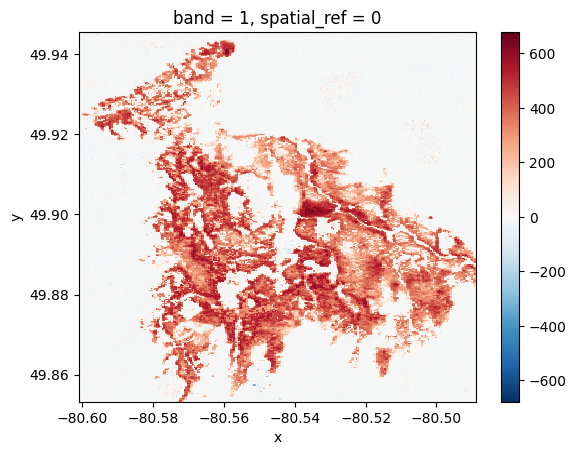

In [205]:
img = rx.open_rasterio("/Users/jgoldman/Desktop/chp3/ltr_pre_post_og_tif/COC16_1997_1038_pp.tif", masked=True)

fp = "/Users/jgoldman/Desktop/chp3/ltr_pre_post/THU37_2007_1662.nc"
img
img = set_attrs(img, fp)
img
pre = img[0]
post = img[1]
post = post.assign_coords({
    "x": pre.x,
    "y": pre.y,})
new_raster=((pre - post)*1000)
nr2 = (pre + 1.001)
nr3 = new_raster / nr2

import exactextract
poly = gpd.read_file("/Users/jgoldman/Desktop/chp3/fire_perimeters/defoliated_or_nondefoliated/ON-QC/defoliated/on-qc-defol-nbac-v1.shp")
polys = poly[poly.Fire_ID == "COC16_1997_1038"]

exact_extract(new_raster, polys, ["mean", "median", "max"])

fig, ax = plt.subplots()
nr3.plot(ax=ax) 

exact_extract(nr3, polys, ["mean", "median", "max"])


polys.crs
nr3.spatial_ref
exact_extract(nr3, polys, ["mean", "median", "max"])


In [255]:
def std_nbr(df):
    df.index.name ="year"
    df.reset_index(inplace=True)
    df['year'] = df['year'].astype('int16')
    df['nbr'] = df['nbr'].where(df['nbr'] < 2, df['nbr']/1000)
    df.set_index('year')
    return(df)



,year,non-defoliated,defoliated
0,1996,0.607154,0.596783
1,1997,-0.116254,-0.013746
2,1998,0.038321,0.061873
3,1999,0.192897,0.137492
4,2000,0.347472,0.213111
5,2001,0.359025,0.288730
6,2002,0.370579,0.364349
7,2003,0.382132,0.439968
8,2004,0.393686,0.515587
9,2005,0.405239,0.591207


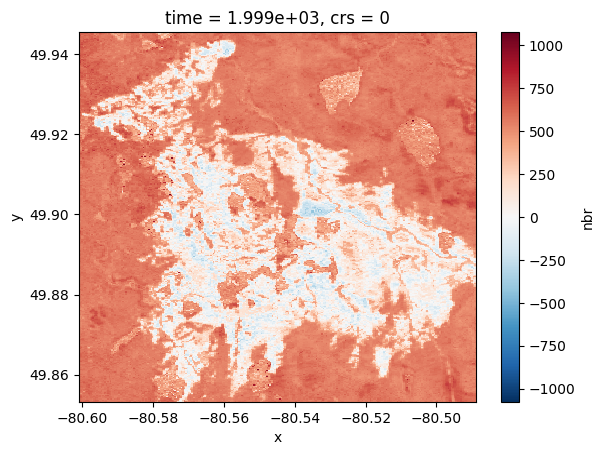

In [272]:
# read in combined
img = rx.open_rasterio("/Users/jgoldman/Desktop/chp3/ltr_nbr_combined/COC16_1997_1038.nc", masked=True)
img[1] = img[1] /1000

img[3].plot()

pixel_values = img.sel(x=-80.52, y=49.90, method="nearest")
pixel_values_df = pixel_values.reset_coords(drop=True).to_dataframe(name="nbr")
df = std_nbr(pixel_values_df)



pixel_values2 = img.sel(x=-80.52, y=49.87, method="nearest")
pixel_values_df2 = pixel_values2.reset_coords(drop=True).to_dataframe(name="nbr")
df2 = std_nbr(pixel_values_df2)

df2 = df2.rename(columns ={'nbr': 'defoliated'})
df = df.rename(columns ={'nbr': 'non-defoliated'})

df = pd.merge(df, df2, how="left", on="year")
df


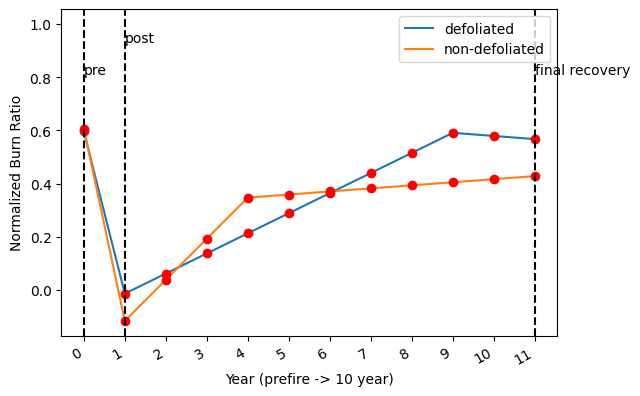

In [302]:
fig, ax = plt.subplots()

#plot the three curves
l = ax.plot(df.index, df[["defoliated", "non-defoliated"]])
ax.legend(iter(l), ["defoliated", "non-defoliated"])

#filter dataset for score not zero

#plot markers on these positions
ax.plot(df.index, df[["defoliated", "non-defoliated"]], "ro")

#plot markers on these positions
#and/or set vertical lines to indicate the position
ax.vlines([0, 1], 0, 1, transform=ax.get_xaxis_transform(), colors='k', ls="--")
ax.vlines(11, 0, 1, transform=ax.get_xaxis_transform(), colors='k', ls="--")


#label x-axis score not zero
ax.set_xticks(df.index)
#beautify the output
ax.set_xlabel("Year (prefire -> 10 year)")
ax.set_ylabel("Normalized Burn Ratio")
fig.autofmt_xdate() 
plt.text(0, .8, 'pre', transform=ax.get_xaxis_transform())
plt.text(1, .9, 'post', transform=ax.get_xaxis_transform())
plt.text(11, .8, 'final recovery', transform=ax.get_xaxis_transform())


plt.show()


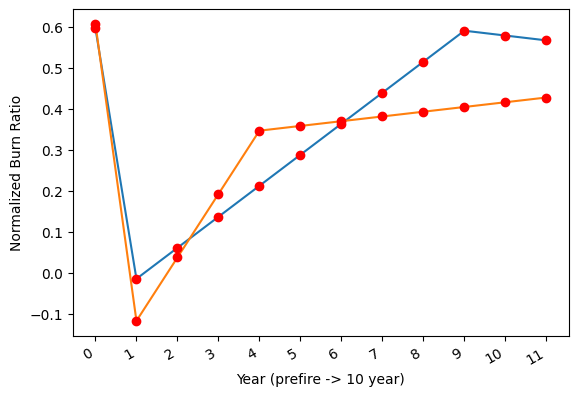

In [304]:
fig, ax = plt.subplots()

#plot the three curves
l = ax.plot(df.index, df[["defoliated", "non-defoliated"]])

#filter dataset for score not zero

#plot markers on these positions
ax.plot(df.index, df[["defoliated", "non-defoliated"]], "ro")

#plot markers on these positions
#and/or set vertical lines to indicate the position


#label x-axis score not zero
ax.set_xticks(df.index)
#beautify the output
ax.set_xlabel("Year (prefire -> 10 year)")
ax.set_ylabel("Normalized Burn Ratio")
fig.autofmt_xdate() 


plt.show()

In [181]:
poly = gpd.read_file("/Users/jgoldman/Desktop/chp3/fire_perimeters/defoliated_or_nondefoliated/ON-QC/defoliated/on-qc-defol-nbac-v1.shp")
poly.iloc[0:11, 0:10]

,Fire_ID,Fire_Year,defoliated,geometry
0,COC16_1997_1038,1997,1.0,"MULTIPOLYGON (((-80.52504 49.86288, -80.52421 ..."
1,DRY27_1996_1121,1996,1.0,"MULTIPOLYGON (((-90.37296 50.06536, -90.37297 ..."
2,FOR13_1987_316,1987,1.0,"MULTIPOLYGON (((-94.35477 48.76280, -94.35408 ..."
3,IGN9_1987_492,1987,1.0,"MULTIPOLYGON (((-90.43158 49.98032, -90.43200 ..."
4,NIP136_1995_1299,1995,1.0,"MULTIPOLYGON (((-86.85845 50.89335, -86.85888 ..."
5,NIP20_2005_1521,2005,1.0,"MULTIPOLYGON (((-87.93455 50.49216, -87.93455 ..."
6,NIP230_1998_821,1998,1.0,"MULTIPOLYGON (((-87.70421 48.75990, -87.70462 ..."
7,NIP44_2000_29,2000,1.0,"MULTIPOLYGON (((-88.06998 50.83981, -88.07059 ..."
8,NIP51_1996_620,1996,1.0,"MULTIPOLYGON (((-87.25656 50.60609, -87.25571 ..."
9,NIP56_1998_832,1998,1.0,"MULTIPOLYGON (((-85.74621 50.16550, -85.74622 ..."


[{'type': 'Feature',
  'properties': {'count': 31517.482421875,
   'median': 4.64237642288208,
   'max': 386.3183288574219,
   'mean': 5.922327041625977}}]

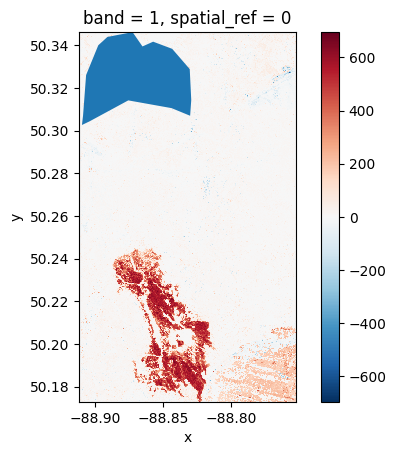

In [200]:
img = rx.open_rasterio("/Users/jgoldman/Desktop/chp3/ltr_pre_post_og_tif/NIP9_1992_1122_pp.tif", masked=True)
#img = rx.open_rasterio("/Users/jgoldman/Desktop/chp3/ltr_nbr_combined/THU37_2007_1662.nc", masked=True)

fp = "/Users/jgoldman/Desktop/chp3/ltr_pre_post/THU37_2007_1662.nc"
img
img = set_attrs(img, fp)
img
pre = img[0]
post = img[1]
post = post.assign_coords({
    "x": pre.x,
    "y": pre.y,})

new_raster=((pre - post)*1000)
nr2 = (pre + 1.001)
nr3 = new_raster / nr2

import exactextract
poly = gpd.read_file("/Users/jgoldman/Desktop/chp3/fire_perimeters/defoliated_or_nondefoliated/ON-QC/non-defoliated/on-qc-non-defol-nbac-v1.shp")
polys = poly[poly.Fire_ID == "NIP9_1992_1122"]

exact_extract(new_raster, polys, ["mean", "median", "max"])

fig, ax = plt.subplots()
nr3.plot(ax=ax) 
polys.plot(ax=ax)
exact_extract(nr3, polys, ["mean", "median", "max", "count"])





In [ ]:
def plot_imgs(img_fp, poly, poly2):
    img = rx.open_rasterio(img_fp, masked=True)
    img = set_attrs(img, img_fp)
    name = getName(img_fp)
    pre = img[0]
    post = img[1]
    post = post.assign_coords({
    "x": pre.x,
    "y": pre.y,})
    new_raster=((pre - post)*1000)
    nr2 = (pre + 1.001)
    nr3 = new_raster / nr2
    poly = gpd.read_file(poly)
    polys = poly[poly.Fire_ID == name]
    poly2 = gpd.read_file(poly2)
    polys2 = poly2[poly2.Fire_ID == name]
    defol =exact_extract(new_raster, polys, ["mean", "median", "max"])
    nondefol = exact_extract(new_raster, polys2, ["mean", "median", "max"])
    fig, ax = plt.subplots(ncols=2)
    new_raster.plot(ax=ax[0]) 
    polys.plot(ax=ax[0])
    new_raster.plot(ax=ax[1]) 
    polys2.plot(ax=ax[1])
    plt.tight_layout()
    return ()


    

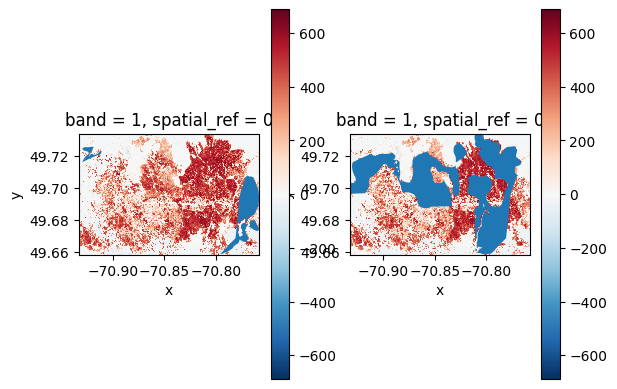

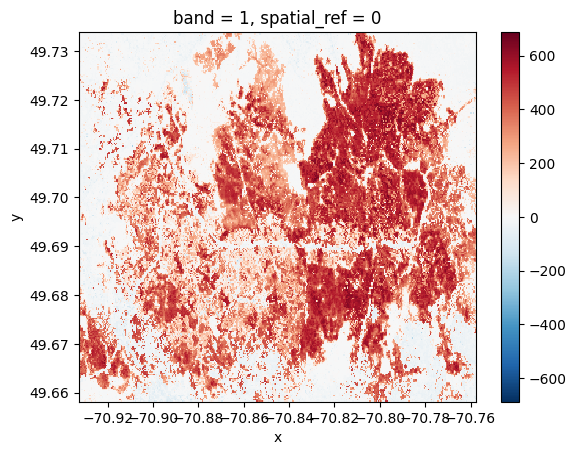

In [330]:
# good example overlap

img = rx.open_rasterio("/Users/jgoldman/Desktop/chp3/ltr_pre_post_og_tif/QC_508_1996_pp.tif", masked=True)
#img = rx.open_rasterio("/Users/jgoldman/Desktop/chp3/ltr_nbr_combined/THU37_2007_1662.nc", masked=True)

fp = "/Users/jgoldman/Desktop/chp3/ltr_pre_post/THU37_2007_1662.nc"
img
img = set_attrs(img, fp)
img
pre = img[0]
post = img[1]
post = post.assign_coords({
    "x": pre.x,
    "y": pre.y,})

new_raster=((pre - post)*1000)
nr2 = (pre + 1.001)
nr3 = new_raster / nr2

import exactextract
poly = gpd.read_file("/Users/jgoldman/Desktop/chp3/fire_perimeters/defoliated_or_nondefoliated/ON-QC/non-defoliated/on-qc-non-defol-nbac-v1.shp")
polys = poly[poly.Fire_ID == "QC_508_1996"]
poly2 = gpd.read_file("/Users/jgoldman/Desktop/chp3/fire_perimeters/defoliated_or_nondefoliated/ON-QC/defoliated/on-qc-defol-nbac-v1.shp")
polys2 = poly2[poly2.Fire_ID == "QC_508_1996"]

exact_extract(new_raster, polys, ["mean", "median", "max"])


fig, ax = plt.subplots(ncols=2)


nr3.plot(ax=ax[0]) 
polys.plot(ax=ax[0])
nr3.plot(ax=ax[1]) 
polys2.plot(ax=ax[1])


exact_extract(nr3, polys, ["mean", "median", "max", "count"])



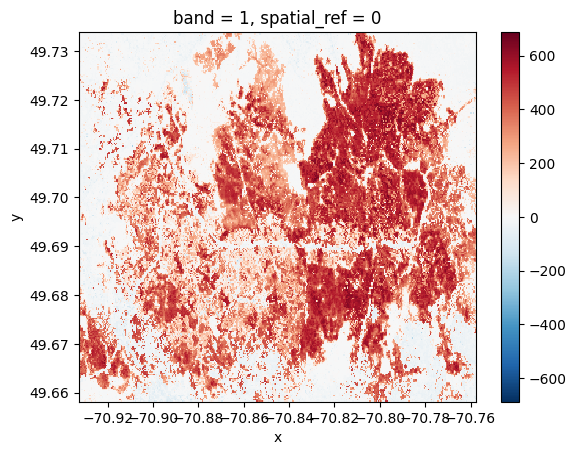

In [331]:
fig, ax = plt.subplots(ncols=1)
nr3.plot(ax=ax) 